Group Members: Dhruv, Rohan, Sarthak, Uday

In [1]:
# !pip install yahoofinance
# !pip install hmmlearn
# !pip install seaborn

In [2]:
%load_ext autoreload
%autoreload 2

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.cross_validation import Pipeline, CustomCrossValidation
from modules.directional_change import *
from modules.hidden_markov_model import make_regime_plots
from modules.logistic_regression import do_all_LR
from modules.MixtureModels import *
from modules.NaiveBayesClassifier import *
from modules.svm import do_all_SVM
from modules.timeseries import *
from modules.trading_strategy import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme()

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

# Pipeline With Cross-Validation

In [4]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8]
}

In [5]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.1305995614876654, 'profit': 0.11294466215834031, 'sharpe': 0.4522180753097107}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.13110416467530533, 'profit': 0.09080363474279118, 'sharpe': 0.3083623657755789}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.14305879638395586, 'profit': 0.08665954285897826, 'sharpe': 0.2944372978219168}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'theta': 0.01}
Iteration: 4 of 45: Training complete.
Iteration: 4 of 45: Loss: {'drawdown': 0.09592641438381

Iteration: 33 of 45: Training complete.
Iteration: 33 of 45: Loss: {'drawdown': 0.173192787639177, 'profit': 0.21010499133694815, 'sharpe': 0.4955654973394068}
Iteration: 34 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.65, 'theta': 0.01}
Iteration: 34 of 45: Training complete.
Iteration: 34 of 45: Loss: {'drawdown': 0.14971796958846756, 'profit': 0.0806240234970681, 'sharpe': 0.29264327205742846}
Iteration: 35 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.65, 'theta': 0.015}
Iteration: 35 of 45: Training complete.
Iteration: 35 of 45: Loss: {'drawdown': 0.151380569897623, 'profit': 0.20477916728119117, 'sharpe': 0.5091128647012351}
Iteration: 36 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.65, 'theta': 0.019999999999999997}
Iteration: 36 of 45: Training complete.
Iteration: 36 of 45: Loss: {'drawdown': 0.173192787639177, 'profit': 0.21010499133694815, 'sharpe': 0.4955654973394068}
Iteration: 37 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.7, 'theta': 

In [6]:
""" Optimal parameters and optimal value of the loss function. """

cv.get_optimal_loss()

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124408,
 'parameters': {'DC_indicator': 'R', 'epsilon': 0.8, 'theta': 0.01}}

In [7]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


In [8]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124408}

In [9]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


In [10]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.10518679766241165,
 'profit': 0.14944332854914522,
 'sharpe': 0.4370891911116876}

In [11]:
""" If you want to look at all the grid search results. """
# sorted(cv.get_losses(), key=lambda d: d['profit'])

' If you want to look at all the grid search results. '

In [12]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 1: 162172800.0
Proportion of time spent in Regime 1: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.2104074889243908}

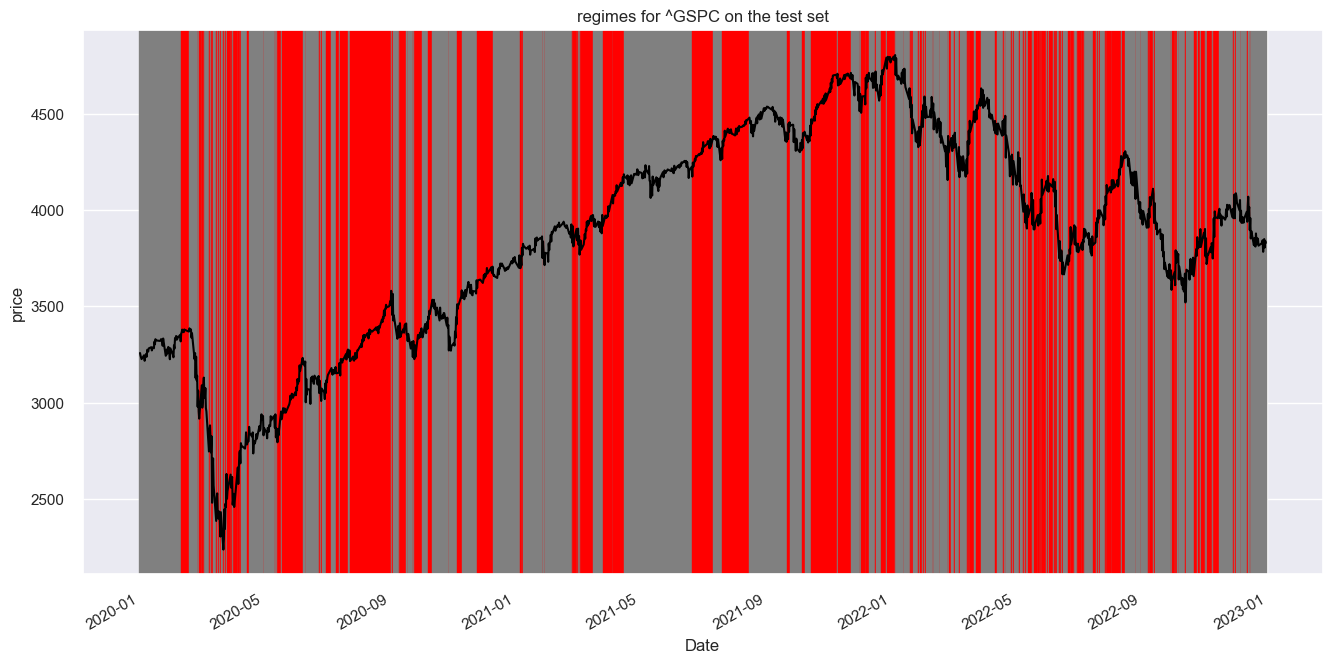

In [21]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

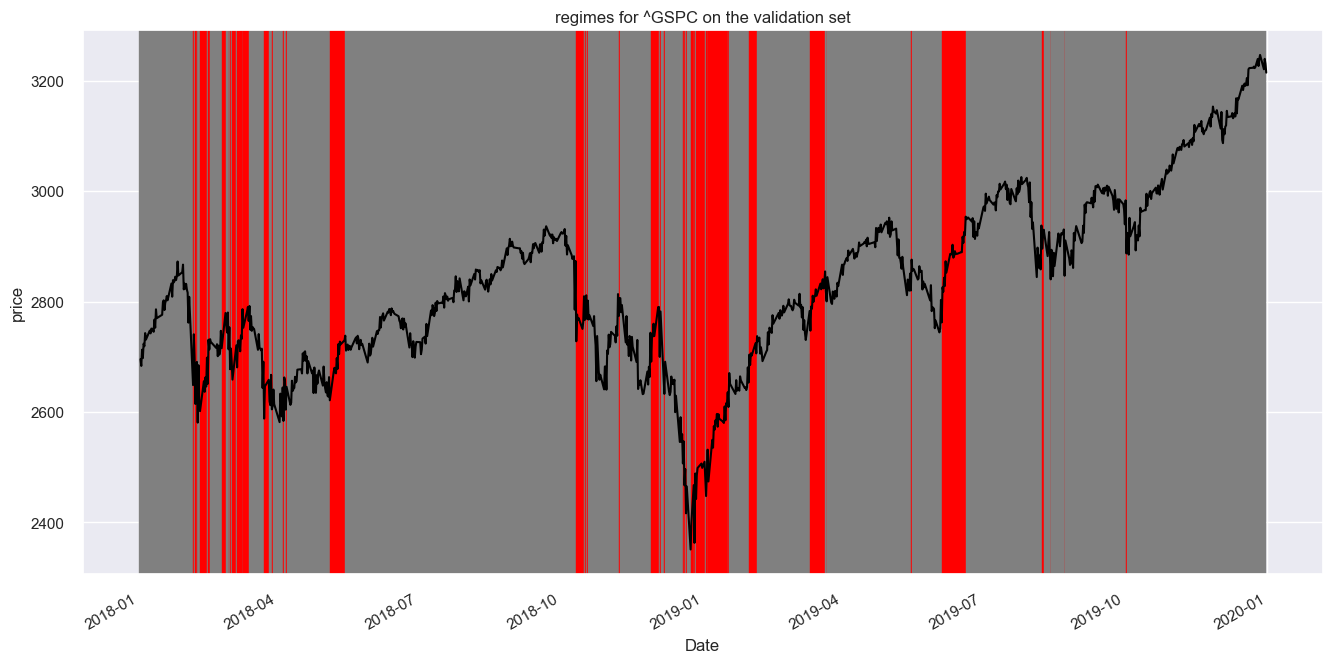

In [22]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

## Visualizing DC indicators

In [23]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

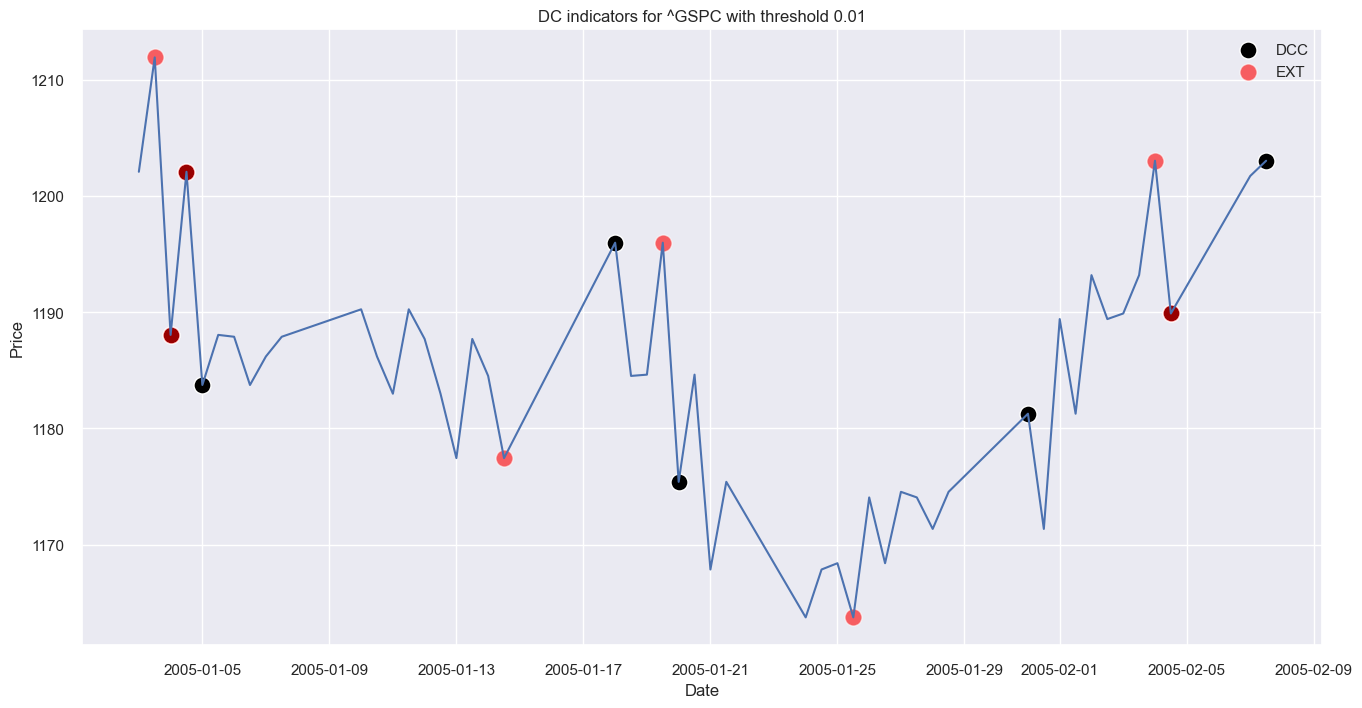

In [24]:
# example
sample_ts = df_ts[:50]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(model.dc['train'])):
    dcc.append(model.dc['train'][i][1])
    dcc_idx.append(model.dc['train'][i][0])
    ext.append( model.dc['train'][i][3] )
    ext_idx.append( model.dc['train'][i][2] )
    
dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[:last_date]#.index
sample_ext = ext.loc[:last_date]#.index

fig,ax = plt.subplots(figsize=(16,8))
features = model.dc['train']
sns.lineplot(data=sample_ts)
sns.scatterplot(x = sample_dcc.index, y = sample_dcc, color='black', s=150, label='DCC',alpha=1)
sns.scatterplot(x = sample_ext.index, y = sample_ext, color='red', s=150, label='EXT',alpha=0.6)

ax.set_title(f"DC indicators for {model.ticker} with threshold {model.theta}")
ax.set_ylabel("Price")
ax.legend()
plt.show()

## Regime Characteristic Plots

In [25]:
model = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
model.fit()
regimes_test = strat_test.regimes_test
regimes_valid = strat_test.regimes_valid

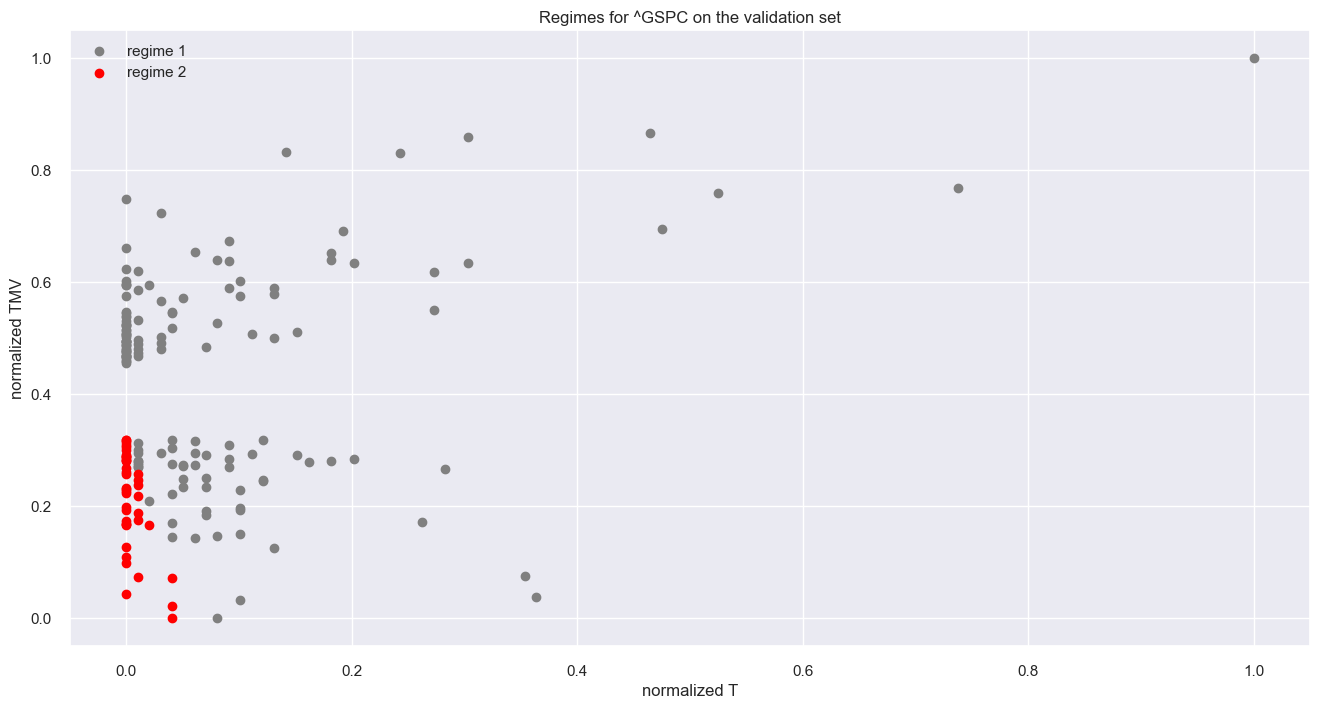

In [26]:
make_regime_plots(regimes_valid, model.tmv['valid'], model.T['valid'], model.ticker, 'validation')

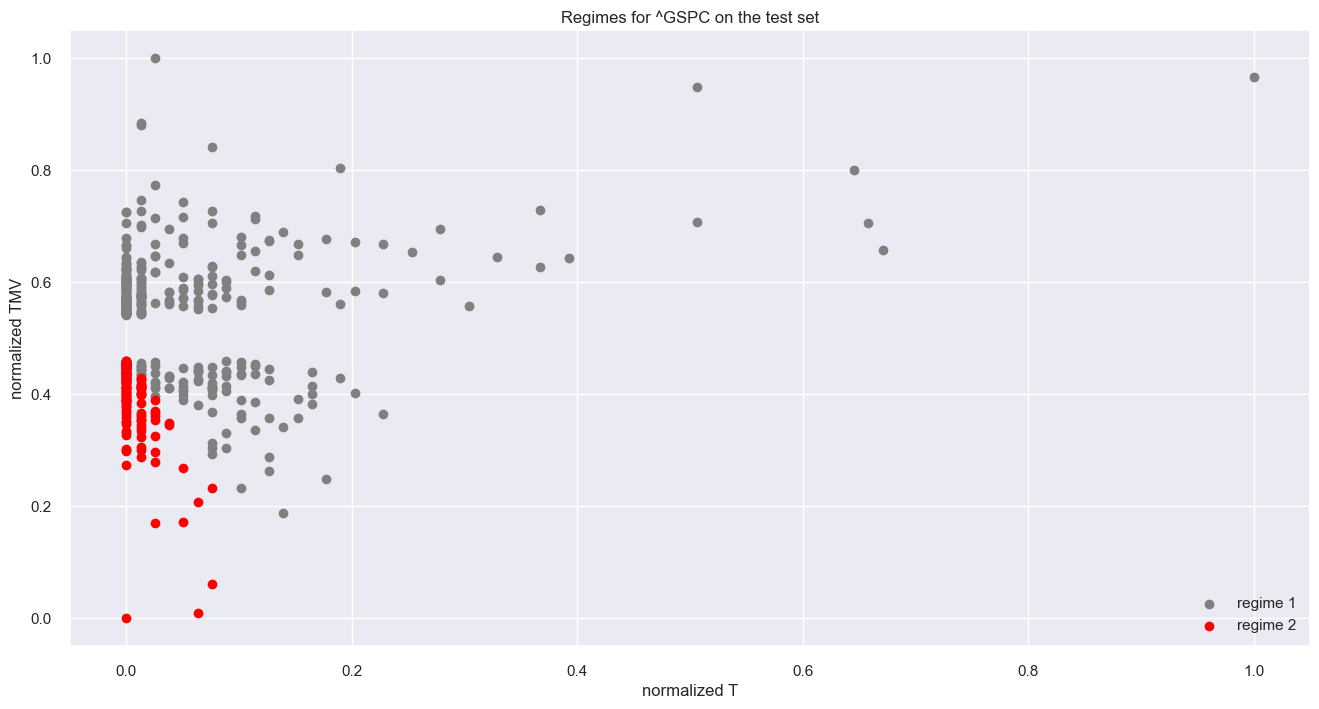

In [27]:
make_regime_plots(regimes_test, model.tmv['test'], model.T['test'], model.ticker, 'test')

## Comparing to Logistic Regression

In [75]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['logistic_regression']
}

In [76]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv2 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv2.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.08494409644887337, 'profit': 0.2922541872604765, 'sharpe': 0.7071558713628109}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.10142322222070867, 'profit': 0.2544798117318581, 'sharpe': 0.5997111969045755}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.18407942398823096, 'profit': 0.09922747653666586, 'sharpe': 0.3070708006165952}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'logi

Iteration: 29 of 45: Training complete.
Iteration: 29 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.35112678742208736}
Iteration: 30 of 45: Parameters: {'DC_indicator': 'TMV', 'epsilon': 0.8, 'model': 'logistic_regression', 'theta': 0.019999999999999997}
Iteration: 30 of 45: Training complete.
Iteration: 30 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.2865943645095791}
Iteration: 31 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.01}
Iteration: 31 of 45: Training complete.
Iteration: 31 of 45: Loss: {'drawdown': 0.14971796958846756, 'profit': 0.0806240234970681, 'sharpe': 0.29264327205742846}
Iteration: 32 of 45: Parameters: {'DC_indicator': 'T', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.015}
Iteration: 32 of 45: Training complete.
Iteration: 32 of 45: Loss: {'drawdown': 0.1513805698976234, 'profit': 0.2077269652686724, 'sharpe': 0

KeyboardInterrupt: 

In [ ]:
""" Optimal parameters and optimal value of the loss function. """

cv2.get_optimal_loss()

In [ ]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv2.get_optimal_parameters())
regime_trade.fit(verbose = True)

In [ ]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

In [ ]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv2.get_optimal_parameters())
control.fit(plot=False, verbose = True)

In [ ]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

In [ ]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

In [ ]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

In [ ]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

# Comparing to SVM

In [ ]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['svm']
}

In [ ]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv3 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv3.fit(data = df_ts, metric='profit', minimize=False)

In [ ]:
""" Optimal parameters and optimal value of the loss function. """

cv3.get_optimal_loss()

In [ ]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv3.get_optimal_parameters())
regime_trade.fit(verbose = True)

In [ ]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

In [ ]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv3.get_optimal_parameters())
control.fit(plot=False, verbose = True)

In [ ]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

In [ ]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

In [ ]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

print(regimes)

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

In [ ]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()